In [94]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [95]:

# Constants
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_earth = 5.972e24  # Earth's mass (kg)
R_earth = 6.371e6  # Earth's radius (m)

# Initial conditions (circular orbit at altitude h)
h = 500e3  # 500 km altitude (m)
# Radial throw speed (m/s) - try changing this!
u_throw = 500  

r0 = R_earth + h  # Initial orbital radius (m)
v0 = np.sqrt(G * M_earth / r0)  # Circular orbital speed (m/s)
print(h, r0, v0)


500000.0 6871000.0 7616.453361670899


In [96]:
# Time settings
t_max = 2 * 2 * np.pi * r0 / v0  # ~2 orbits (s)
dt = 10  # Time step (s)
t = np.arange(0, t_max, dt)

In [97]:
# Function to compute derivatives (for odeint)
def motion(state, t):
    r, vr, theta, omega = state
    drdt = vr
    dvrdt = r * omega**2 - G * M_earth / r**2
    dthetadt = omega
    domegadt = -2 * vr * omega / r
    return [drdt, dvrdt, dthetadt, domegadt]


In [98]:

# Initial state of the spacecraft (circular orbit)
initial_state_spacecraft = [r0, 0, 0, v0 / r0]

# Simulate spacecraft orbit (for reference)
states_spacecraft = odeint(motion, initial_state_spacecraft, t)
r_spacecraft = states_spacecraft[:, 0]
theta_spacecraft = states_spacecraft[:, 2]

# Now simulate the thrown mass

initial_state_mass = [r0, u_throw, 0, v0 / r0]  # Same r, θ but different vr

states_mass = odeint(motion, initial_state_mass, t)
r_mass = states_mass[:, 0]
theta_mass = states_mass[:, 2]


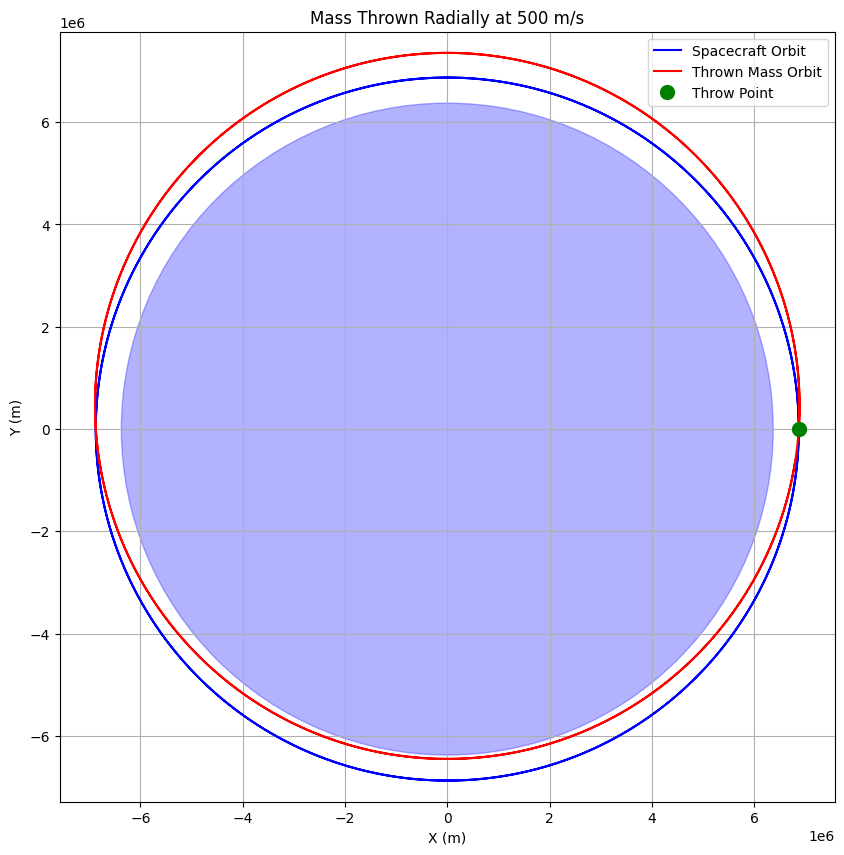

In [99]:

# Convert to Cartesian coordinates for plotting
x_spacecraft = r_spacecraft * np.cos(theta_spacecraft)
y_spacecraft = r_spacecraft * np.sin(theta_spacecraft)
x_mass = r_mass * np.cos(theta_mass)
y_mass = r_mass * np.sin(theta_mass)

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_spacecraft, y_spacecraft, 'b-', label="Spacecraft Orbit")
plt.plot(x_mass, y_mass, 'r-', label="Thrown Mass Orbit")
plt.plot(x_spacecraft[0], y_spacecraft[0], 'go', markersize=10, label="Throw Point")
earth = Circle((0, 0), R_earth, color='blue', alpha=0.3)
plt.gca().add_patch(earth)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f"Mass Thrown Radially at {u_throw} m/s")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

In [100]:
r_mass_final = min(r_mass)
theta_mass_final = theta_mass[-1]   
r_mass_final > R_earth

np.True_

Safe orbit. Perigee altitude = 76.73 km


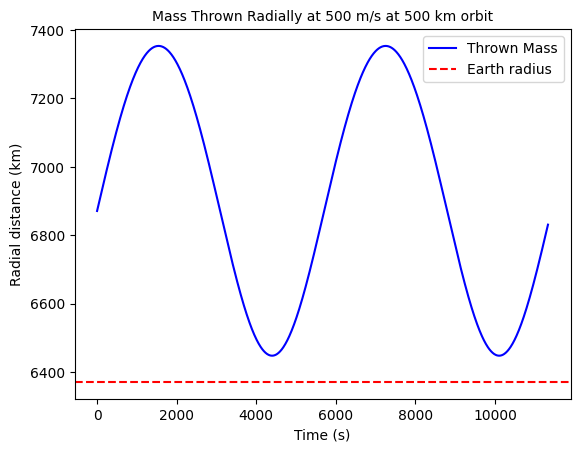

In [101]:

# Simulate the mass's orbit (throw speed = 800 m/s, safe)
#u_throw = 1000  
initial_state_mass = [r0, u_throw, 0, v0 / r0]
t_max = 2 * 2 * np.pi * r0 / v0  # ~2 orbits
t = np.arange(0, t_max, 10)
states_mass = odeint(motion, initial_state_mass, t)
r_mass = states_mass[:, 0]

# Calculate perigee
perigee = np.min(r_mass)
if perigee < R_earth:
    print(f"CRASH! Perigee = {perigee/1000:.2f} km (< Earth radius)")
else:
    print(f"Safe orbit. Perigee altitude = {(perigee - R_earth)/1000:.2f} km")

# Plot (optional)
plt.title(f"Mass Thrown Radially at {u_throw} m/s at {h/1000:.0f} km orbit", fontsize=10)
plt.plot(t, r_mass/1000, 'b-', label="Thrown Mass")
plt.axhline(R_earth/1000, color='red', linestyle='--', label='Earth radius')
plt.xlabel('Time (s)')
plt.ylabel('Radial distance (km)')
plt.legend()
plt.show()

Throw speeds more than 597.75 m/s are UNSAFE (perigee < Earth radius)
Safe speeds: u_throw < 597.75 m/s
Safe orbit: Perigee = 6378.76 km


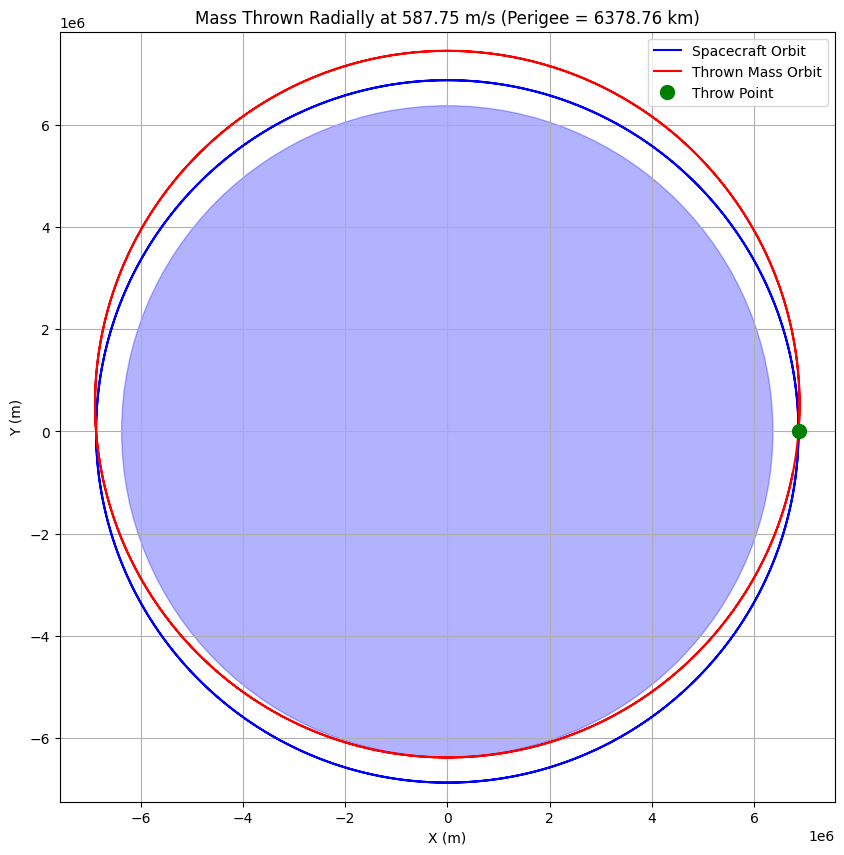

In [102]:

# Function to calculate perigee
def calculate_perigee(r0, v0, u_throw):
    v_new = np.sqrt(v0**2 + u_throw**2)  # Total velocity after throw
    energy = 0.5 * v_new**2 - G * M_earth / r0  # Specific orbital energy
    a = -G * M_earth / (2 * energy)  # Semi-major axis
    h_angular = r0 * v0  # Specific angular momentum (conserved)
    e = np.sqrt(1 + 2 * energy * h_angular**2 / (G**2 * M_earth**2))  # Eccentricity
    r_peri = a * (1 - e)
    return r_peri

def find_safe_throw_speeds(r0, v0, R_earth, u_max=3000, tol=1e-3):
    """Find the range of u_throw where perigee >= R_earth."""
    # Find u_min (first speed where perigee < R_earth)
    u_min = 0
    u_test = 0
    while u_test < u_max:
        r_peri = calculate_perigee(r0, v0, u_test)
        if r_peri < R_earth:
            u_min = u_test
            break
        u_test += tol * 10

    # Find u_max (speed where perigee rises back above R_earth)
    u_max_safe = u_min
    for u in np.linspace(u_min, u_max, 1000):
        r_peri = calculate_perigee(r0, v0, u)
        if r_peri >= R_earth and u > u_min:
            u_max_safe = u
            break

    return u_min, u_max_safe

# Usage
u_min, u_max_safe = find_safe_throw_speeds(r0, v0, R_earth)
print(f"Throw speeds more than {u_max_safe:.2f} m/s are UNSAFE (perigee < Earth radius)")
print(f"Safe speeds: u_throw < {u_max_safe:.2f} m/s")

u_throw = u_max_safe - 10  # Test the maximum safe speed

# Check if the throw is safe
r_peri = calculate_perigee(r0, v0, u_throw)
if r_peri < R_earth:
    print(f"WARNING: Throw speed {u_throw} m/s will cause Earth impact (perigee = {r_peri/1000:.2f} km)!")
else:
    print(f"Safe orbit: Perigee = {r_peri/1000:.2f} km")

    # Simulate spacecraft orbit (reference)
    t_max = 2 * 2 * np.pi * r0 / v0  # ~2 orbits (s)
    dt = 10  # Time step (s)
    t = np.arange(0, t_max, dt)
    initial_state_spacecraft = [r0, 0, 0, v0 / r0]
    states_spacecraft = odeint(motion, initial_state_spacecraft, t)
    r_spacecraft = states_spacecraft[:, 0]
    theta_spacecraft = states_spacecraft[:, 2]

    # Simulate thrown mass
    initial_state_mass = [r0, u_throw, 0, v0 / r0]
    states_mass = odeint(motion, initial_state_mass, t)
    r_mass = states_mass[:, 0]
    theta_mass = states_mass[:, 2]

    # Convert to Cartesian coordinates
    x_spacecraft = r_spacecraft * np.cos(theta_spacecraft)
    y_spacecraft = r_spacecraft * np.sin(theta_spacecraft)
    x_mass = r_mass * np.cos(theta_mass)
    y_mass = r_mass * np.sin(theta_mass)

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.plot(x_spacecraft, y_spacecraft, 'b-', label="Spacecraft Orbit")
    plt.plot(x_mass, y_mass, 'r-', label="Thrown Mass Orbit")
    plt.plot(x_spacecraft[0], y_spacecraft[0], 'go', markersize=10, label="Throw Point")
    earth = Circle((0, 0), R_earth, color='blue', alpha=0.3)
    plt.gca().add_patch(earth)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f"Mass Thrown Radially at {u_throw:.2f} m/s (Perigee = {r_peri/1000:.2f} km)")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()

In [103]:


# Simulate for u_throw = 500 m/s (safe) and 800 m/s (crash)
u_throw_list = [500, 800]
t = np.arange(0, 2 * 2 * np.pi * r0 / v0, 10)  # ~2 orbits

for u_throw in u_throw_list:
    states = odeint(motion, [r0, u_throw, 0, v0 / r0], t)
    r_mass = states[:, 0]
    perigee = np.min(r_mass)
    print(f"u_throw = {u_throw} m/s → Perigee = {perigee/1000:.2f} km")

u_throw = 500 m/s → Perigee = 6447.73 km
u_throw = 800 m/s → Perigee = 6217.90 km


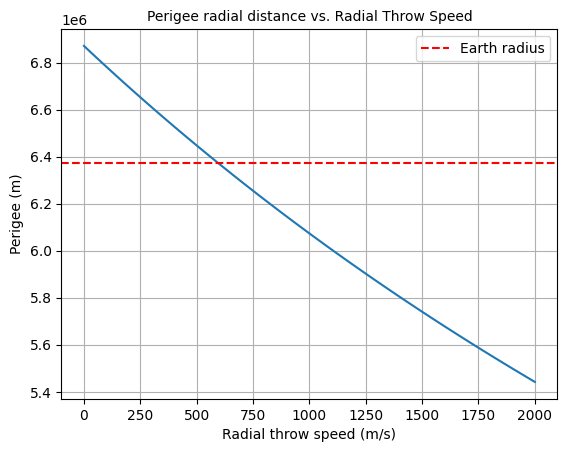

In [104]:
# Test radial throws from 1 m/s to 1000 m/s
u_throws = np.linspace(0, 2000, 100)
perigees = [calculate_perigee(r0, v0, u) for u in u_throws]

# Perigee radius vs. Radial Throw Speed
plt.plot(u_throws, perigees)
plt.axhline(R_earth, color='red', linestyle='--', label='Earth radius')
plt.xlabel('Radial throw speed (m/s)')
plt.ylabel('Perigee (m)')
plt.title('Perigee radial distance vs. Radial Throw Speed',fontsize=10)
plt.legend()
plt.grid()
plt.show()

First unsafe throw: 606.06 m/s


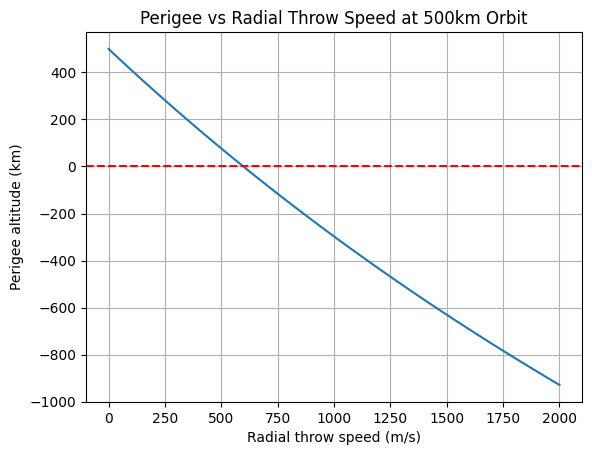

In [105]:
# Find when perigee < Earth radius
for u, rp in zip(u_throws, perigees):
    if rp < R_earth:
        print(f"First unsafe throw: {u:.2f} m/s")
        break

# Plot results
# Perigee altitude vs. Radial Throw Speed
plt.plot(u_throws, [(rp-R_earth)/1000 for rp in perigees])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Radial throw speed (m/s)')
plt.ylabel('Perigee altitude (km)')
plt.title('Perigee vs Radial Throw Speed at 500km Orbit')
plt.grid()
plt.show()